In [23]:
import tensorflow as tf

tf.get_logger().setLevel("WARNING")

In [24]:
import yfinance as yf
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import math

from keras.utils import set_random_seed

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


set_random_seed(69)


def root_mean_square_error(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


def paklaidos(y_true, y_pred):
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    RMSE = root_mean_square_error(y_true, y_pred)
    print(f"MAE = {MAE}")
    print(f"MAPE = {MAPE}")
    print(f"RMSE = {RMSE}")

In [25]:
akcija = "META"
pradzia = "2021-11-01"
pabaiga = "2023-11-01"
intervalas = "1d"

df = yf.download(akcija, start=pradzia, end=pabaiga, interval=intervalas)

df.dropna(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

In [27]:
training_data_size = int(len(scaled_data) * 0.8)

train_data = scaled_data[0:training_data_size]
test_data = scaled_data[training_data_size : len(scaled_data)]

In [28]:
periodas = 15


def duomenys(dataset, periodas):
    dataX, dataY = [], []
    for i in range(periodas, len(dataset)):
        dataX.append(dataset[i - periodas : i, 0])
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
x_train, y_train = duomenys(train_data, periodas)
x_test, y_test = duomenys(test_data, periodas)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
from keras.utils import set_random_seed

set_random_seed(69)
model = Sequential()
model.add(LSTM(units=200, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=200, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=200))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [31]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=200, batch_size=64, verbose=0, validation_split=0.2)

In [32]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 27ms/step


In [33]:
original_data = scaler.inverse_transform(test_data[periodas:])

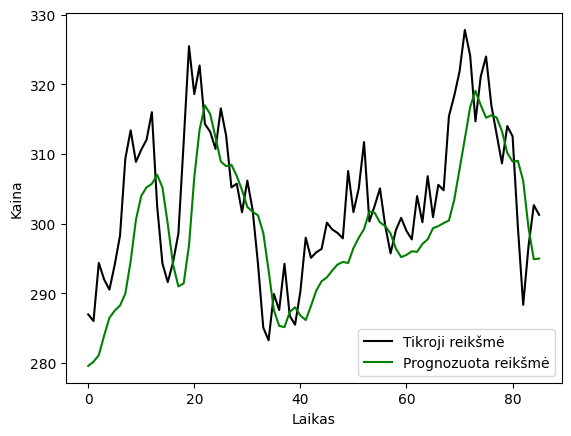

In [34]:
plt.plot(original_data, color="black", label="Tikroji reikšmė")
plt.plot(predictions, color="green", label="Prognozuota reikšmė")
plt.xlabel("Laikas")
plt.ylabel("Kaina")
plt.legend()
plt.show()

In [35]:
test_data_2 = df["Close"].shift(1)
test_data_2 = test_data_2[training_data_size + periodas : len(test_data_2)]
test_data_2.reset_index(drop=True, inplace=True)

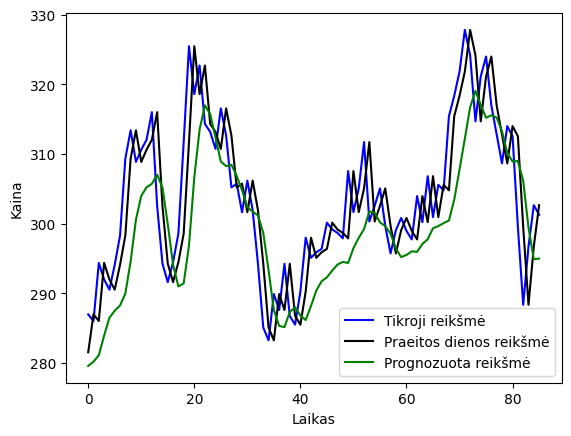

In [36]:
plt.plot(original_data, color="blue", label="Tikroji reikšmė")
plt.plot(test_data_2, color="black", label="Praeitos dienos reikšmė")
plt.plot(predictions, color="green", label="Prognozuota reikšmė")
plt.xlabel("Laikas")
plt.ylabel("Kaina")
plt.legend()
plt.show()

In [37]:
paklaidos(original_data, predictions)

MAE = 6.944299742232923
MAPE = 0.022734273206259977
RMSE = 8.688241845015302
